In [13]:
import json
import numpy as np
import pandas as pd

from nlp.sentiment import get_sentiment
from sklearn.feature_extraction.text import TfidfVectorizer
from nlp.topic_modelling import TopicModelling

from nlp.preprocessing import clean

from nltk.corpus import stopwords
stop_words_en = stopwords.words("english")

import seaborn as sns
%matplotlib inline


# Load the Dataset

In [14]:
sofia_airbnb = pd.read_csv("../data/sofia_airbnb_reviews.csv")

In [15]:
sofia_airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306 entries, 0 to 305
Data columns (total 5 columns):
lat               306 non-null float64
long              306 non-null float64
reviews           306 non-null object
sentiments        306 non-null object
mean_sentiment    306 non-null float64
dtypes: float64(3), object(2)
memory usage: 12.0+ KB


***

# Quick stats

In [16]:
sofia_airbnb.head()

,lat,long,reviews,sentiments,mean_sentiment
0,42.697323,23.318125,"[""Great apartment with the perfect location if...","[0.45583333333333337, 0.2804761904761905, 0.40...",0.454853
1,42.690397,23.327108,"[""This apartment is absolutely AMAZING! Everyt...","[0.6023809523809524, 1.0, 0.625, 0.8, 0.399999...",0.411689
2,42.692549,23.307022,"[""The place is really stylish and cozy. Hosts ...","[0.29444444444444445, 0.263, 0.339259259259259...",0.161913
3,42.690125,23.322050,"[""We stayed for two nights and everything was ...","[0.2898148148148148, 0.5707407407407408, 0.397...",0.336324
4,42.692787,23.330109,"[""One of the best locations in Sofia!"", ""Centr...","[1.0, 0.3333333333333333, 0.5028571428571429, ...",0.341235


In [17]:
sofia_airbnb.describe()

,lat,long,mean_sentiment
count,306.000000,306.000000,306.000000
mean,42.692683,23.323903,0.372832
std,0.010008,0.015763,0.054759
min,42.647482,23.253589,0.138154
25%,42.689313,23.317093,0.341861
50%,42.693428,23.322385,0.373597
75%,42.699408,23.330179,0.403898
max,42.711740,23.380464,0.601389


***

# Exploring the reviews

## Remove NaN and redundant reviews

In [18]:
sofia_airbnb.dropna(inplace=True)
sofia_airbnb.reset_index(inplace=True)
sofia_airbnb.drop("index", axis=1, inplace=True)

In [19]:
for i in range(sofia_airbnb.shape[0]):
    try:
        json.loads(sofia_airbnb["reviews"][i])
    except json.JSONDecodeError:
        sofia_airbnb.drop(i, axis=0, inplace=True)

## Sentiment Analysis

### Quaintitative

In [20]:
sentiments = []
mean_sentiment = []

for i in range(sofia_airbnb.shape[0]):
    scores = []
    for review in json.loads(sofia_airbnb["reviews"][i]):
        scores.append(get_sentiment(review))     
        
    sentiments.append(scores)
    mean_sentiment.append(np.mean(scores))
    
sofia_airbnb["sentiments"] = sentiments
sofia_airbnb["mean_sentiment"] = mean_sentiment

/Users/victor/.local/share/virtualenvs/Peper-Analysis-eBzTI8A5/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


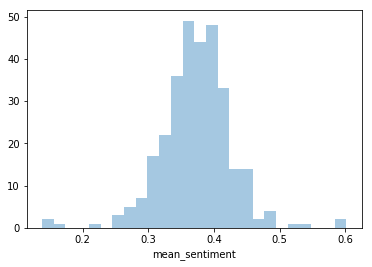

In [21]:
sns.distplot(sofia_airbnb["mean_sentiment"], kde=False);

### Save the `mean_sentiment`s to `JSON`

In [22]:
jsonArray = ''
for index, row in sofia_airbnb.iterrows():
    x = {
       "lat": row["lat"],
       "long": row["long"],
       "mean_sentiment": row["mean_sentiment"]
    }
    jsonArray += json.dumps(x)+','

## Topic Modelling

In [23]:
for loc in sofia_airbnb.values:
    reviews = json.loads(loc[2])
    for review in reviews:
        print(TopicModelling(review).get_topics())
        

[['downtown', 'perfect', 'something'], ['need', 'clean', 'anything'], ['need', 'clean', 'anything']]
[['fantastic', 'stay', 'sofia'], ['sofia', 'communicating', 'helpful'], ['super', 'classy', 'apartment']]
[['great', 'flat', 'really'], ['close', 'flat', 'really'], ['great', 'flat', 'really']]
[['u', 'word', 'spot'], ['town', 'best', 'tony'], ['town', 'best', 'tony']]
[['it', 'recommend', 'share'], ['it', 'recommend', 'share'], ['toilet', 'vitosha', 'share']]
[['pastry', 'excellent', 'location'], ['nearby', 'making', 'coffee'], ['walking', 'distance', 'short']]
[['recommend', 'sofia', 'home'], ['recommendation', 'see', 'question'], ['great', 'location', 'experience']]
[['guy', 'thank', 'nice'], ['good', 'yard', 'silent'], ['pretty', 'room', 'nice']]
[['rent', 'people', 'place'], ['great', 'people', 'place'], ['rent', 'people', 'place']]
[['close', 'everything', 'nice'], ['close', 'everything', 'nice'], ['close', 'everything', 'nice']]
[['place', 'problem', 'last'], ['place', 'problem',

KeyboardInterrupt: 

## Term-Frequency x Inverse-Doc-Freq

In [24]:
for loc in sofia_airbnb.values:
    tf_idf = TfidfVectorizer(use_idf=True, stop_words=stop_words_en)
    X = tf_idf.fit_transform(json.loads(loc[2]))
    
    tfs = np.mean(X.todense(), axis=0) * .1
    scores = np.multiply(tfs, tf_idf.idf_.reshape(tfs.shape))
    
    terms = np.array(tf_idf.get_feature_names()).reshape(tfs.shape)
    zipped = np.hstack((terms.T, scores.T)).tolist()
    print(np.array(sorted(zipped, key=lambda x: x[1], reverse=True)))
    
    print('='*100)
    print('='*100)

[['great' '0.018019997726693913']
 ['nice' '0.016693974105045136']
 ['place' '0.01580768956396819']
 ['perfect' '0.014398912391173859']
 ['location' '0.012863950216410878']
 ['host' '0.012612399043261112']
 ['stay' '0.011522926510105192']
 ['sofia' '0.011262514913718652']
 ['everything' '0.011010702834465844']
 ['good' '0.010893547754776188']
 ['apartment' '0.010870970098990193']
 ['super' '0.010815900132045819']
 ['really' '0.010773459928060357']
 ['tony' '0.010731512460247294']
 ['people' '0.010519088764076279']
 ['close' '0.010012034474439055']
 ['central' '0.009681585511907705']
 ['us' '0.009510642700914753']
 ['cozy' '0.009461016839242468']
 ['city' '0.009319772342471116']
 ['vera' '0.00925969421328269']
 ['room' '0.009255003796145016']
 ['clean' '0.00925211573766871']
 ['pleased' '0.009036957437282856']
 ['heart' '0.008733124667117651']
 ['recommended' '0.008328505289596817']
 ['la' '0.007826881205793697']
 ['definitely' '0.007522871607100138']
 ['comfortable' '0.0074775848241495

[['place' '0.012568839391011154']
 ['great' '0.011577320752786904']
 ['good' '0.011443477794393867']
 ...
 ['taking' '0.000588015825892587']
 ['term' '0.000588015825892587']
 ['though' '0.000588015825892587']]
[['nice' '0.014703883385361095']
 ['place' '0.013300855856613164']
 ['great' '0.012428926465484911']
 ...
 ['tendrás' '0.0002909344128369041']
 ['transporte' '0.0002909344128369041']
 ['vuelo' '0.0002909344128369041']]
[['place' '0.013708188628071523']
 ['stay' '0.013492853260046948']
 ['everything' '0.013231069068044811']
 ['good' '0.012844009881842663']
 ['nice' '0.011906363287468807']
 ['small' '0.011437181401443088']
 ['great' '0.01120957082917423']
 ['comfortable' '0.011094011954228957']
 ['location' '0.011004175087708642']
 ['one' '0.010486527284771651']
 ['well' '0.010470488465460955']
 ['center' '0.01013669887232194']
 ['tiny' '0.010110517877609592']
 ['price' '0.01008240648120937']
 ['sofia' '0.010027834481419392']
 ['ok' '0.009588788984059505']
 ['apartment' '0.00956327

[['great' '0.01152918307280518']
 ['perfect' '0.010341890091419477']
 ['apartment' '0.010288277522682812']
 ...
 ['toallas' '0.0001202842116506737']
 ['tuvo' '0.0001202842116506737']
 ['utensilios' '0.0001202842116506737']]
[['stay' '0.016062099361358585']
 ['great' '0.015730584214443923']
 ['place' '0.012111027794041017']
 ...
 ['visit' '0.0008043120187244477']
 ['warring' '0.0008043120187244477']
 ['yard' '0.0008043120187244477']]
[['great' '0.018561522174225818']
 ['stay' '0.015901273399059408']
 ['vera' '0.015260929560647573']
 ['place' '0.014662888659716263']
 ['location' '0.013826497848259083']
 ['really' '0.013630793855874096']
 ['host' '0.013081096228213662']
 ['would' '0.012837639158741195']
 ['nice' '0.012344418743879607']
 ['und' '0.011406485787596458']
 ['apartment' '0.01093046716842412']
 ['sofia' '0.010780460027036691']
 ['fabulous' '0.010423506276703652']
 ['value' '0.009568234308001602']
 ['money' '0.00946099673210882']
 ['superb' '0.009153186128967398']
 ['highly' '0.0

[['place' '0.013217738593327873']
 ['nice' '0.011980378901935776']
 ['perfect' '0.011884736301020703']
 ...
 ['usar' '0.00016868669669111415']
 ['vecinos' '0.00016868669669111415']
 ['volveré' '0.00016868669669111415']]
[['apartment' '0.010884198464918707']
 ['great' '0.01069526103392351']
 ['nice' '0.010304778828872142']
 ...
 ['wakker' '0.0002056369667302061']
 ['woonkamer' '0.0002056369667302061']
 ['zeker' '0.0002056369667302061']]
[['great' '0.0111743548553913']
 ['apartment' '0.011137642019379076']
 ['place' '0.010200991410846927']
 ...
 ['voyage' '0.0001710793658742131']
 ['été' '0.0001710793658742131']
 ['être' '0.0001710793658742131']]
[['great' '0.014015292020893936']
 ['place' '0.01131293728574549']
 ['apartment' '0.011164116525774164']
 ...
 ['yolanda' '0.00022027200197879']
 ['zapatillas' '0.00022027200197879']
 ['íbamos' '0.00022027200197879']]
[['great' '0.015125730765540355']
 ['perfect' '0.012662857623214346']
 ['place' '0.012171929052374896']
 ...
 ['voor' '0.00040525

[['nice' '0.013449730364769168']
 ['great' '0.01289399051842356']
 ['place' '0.01254450570127841']
 ...
 ['utilice' '0.00021314203909496103']
 ['viaje' '0.00021314203909496103']
 ['vida' '0.00021314203909496103']]
[['great' '0.01424425982426324']
 ['place' '0.01327617399866857']
 ['nice' '0.012422413521685122']
 ...
 ['χαλάρωση' '0.00035623425276842997']
 ['χρειαστήκαμε' '0.00035623425276842997']
 ['ότι' '0.00035623425276842997']]
[['great' '0.01089407018838859']
 ['apartment' '0.010858442235775487']
 ['place' '0.010331150335571348']
 ...
 ['wunderschön' '0.00029270898037122266']
 ['zentrum' '0.00029270898037122266']
 ['zum' '0.00029270898037122266']]
[['good' '0.01485541383011674']
 ['great' '0.01380224648559944']
 ['nice' '0.012073792456144915']
 ...
 ['used' '0.0005907211836554097']
 ['wait' '0.0005907211836554097']
 ['washing' '0.0005907211836554097']]
[['abend' '9.973639573423865e-05']
 ['aber' '9.973639573423865e-05']
 ['allem' '9.973639573423865e-05']
 ...
 ['vitrage' '0.0001447

[['great' '0.014045818237253583']
 ['apartment' '0.012112335044325606']
 ['place' '0.011332722823922673']
 ...
 ['über' '0.000227791270933682']
 ['überall' '0.000227791270933682']
 ['überlegt' '0.000227791270933682']]
[['perfect' '0.015166242874132504']
 ['great' '0.014863788447607737']
 ['nice' '0.014765074172856423']
 ...
 ['tarde' '0.0005598990245296654']
 ['tasa' '0.0005598990245296654']
 ['teniendo' '0.0005598990245296654']]
[['great' '0.018242384030477943']
 ['place' '0.017723940353098093']
 ['nice' '0.016194276105954288']
 ...
 ['visité' '0.0005521000148617955']
 ['étage' '0.0005521000148617955']
 ['être' '0.0005521000148617955']]
[['great' '0.015736404151794673']
 ['location' '0.01146122620432242']
 ['apartment' '0.011371261797693377']
 ...
 ['verde' '0.0003015272267859322']
 ['vino' '0.0003015272267859322']
 ['zonas' '0.0003015272267859322']]
[['place' '0.012034496854542668']
 ['apartment' '0.011294843988512701']
 ['stay' '0.01121470897687239']
 ...
 ['winkelcentrum' '0.000457

[['great' '0.010497084940562156']
 ['apartment' '0.00970645535547839']
 ['lovely' '0.009534255157157105']
 ...
 ['winkels' '0.00023267565248077186']
 ['zes' '0.00023267565248077186']
 ['zoals' '0.00023267565248077186']]
[['great' '0.01592424233529469']
 ['place' '0.01315908061291581']
 ['yory' '0.011470001893412173']
 ...
 ['wirklich' '0.0004154762373365018']
 ['wohnt' '0.0004154762373365018']
 ['über' '0.0004154762373365018']]
[['clean' '0.01592918287895669']
 ['everything' '0.015216543402408475']
 ['great' '0.01448050214585786']
 ...
 ['world' '0.000953967464588151']
 ['writing' '0.000953967464588151']
 ['yet' '0.000953967464588151']]
[['apartment' '0.014434146628388489']
 ['great' '0.01298589587185277']
 ['flat' '0.011020474716546292']
 ...
 ['without' '0.0014629348060340133']
 ['work' '0.0014629348060340133']
 ['worth' '0.0014629348060340133']]
[['nice' '0.01787876753673642']
 ['good' '0.016185922824134717']
 ['close' '0.0154168139747509']
 ['comfortable' '0.014774352137844804']
 [

[['place' '0.014079965874802229']
 ['nice' '0.013752015423637865']
 ['good' '0.012727513878605854']
 ...
 ['water' '0.0003903745042669385']
 ['website' '0.0003903745042669385']
 ['world' '0.0003903745042669385']]
[['great' '0.01329391009165696']
 ['place' '0.012528237743812072']
 ['good' '0.011159009553793805']
 ...
 ['étage' '0.0003250680414781926']
 ['été' '0.0003250680414781926']
 ['être' '0.0003250680414781926']]
[['great' '0.0171720606933891']
 ['place' '0.011957019698894336']
 ['perfect' '0.011814007730930796']
 ...
 ['woord' '0.0001900023687307718']
 ['zoekt' '0.0001900023687307718']
 ['zowel' '0.0001900023687307718']]
[['great' '0.014212584630017023']
 ['place' '0.012789432655686404']
 ['nice' '0.01207633303601999']
 ...
 ['upon' '0.0007253300018786003']
 ['waterfall' '0.0007253300018786003']
 ['worked' '0.0007253300018786003']]
[['good' '0.015203778923006001']
 ['great' '0.013132096144429846']
 ['perfect' '0.01281238723000284']
 ...
 ['value' '0.0004977619956208383']
 ['vegeta

 ['sketchy' '0.014781500896991385']]
[['us' '0.01517503643689974']
 ['apartment' '0.014661623243538187']
 ['cozy' '0.01267968190917123']
 ...
 ['within' '0.000993452123609984']
 ['working' '0.000993452123609984']
 ['xxxx' '0.000993452123609984']]
[['great' '0.023034488096054948']
 ['place' '0.01862898844806014']
 ['host' '0.015521483458252642']
 ['apartment' '0.012497161510182557']
 ['definitely' '0.011678450447990223']
 ['tsveta' '0.011528464911287508']
 ['nice' '0.011230690084078222']
 ['friendly' '0.011055894934891073']
 ['central' '0.010977538069185364']
 ['good' '0.01074108603544978']
 ['location' '0.010632579587057047']
 ['clean' '0.009863032288796559']
 ['city' '0.009558470573748704']
 ['stay' '0.009270500562576394']
 ['view' '0.00900297076360343']
 ['helpfull' '0.008881057482304514']
 ['center' '0.008508772236023539']
 ['gern' '0.00848158492450394']
 ['immer' '0.00848158492450394']
 ['wieder' '0.00848158492450394']
 ['experience' '0.00823395681711487']
 ['hosts' '0.008192770250

[['perfect' '0.016957009201613936']
 ['great' '0.015082690319400838']
 ['place' '0.013311408361760087']
 ['apartment' '0.012326541164214992']
 ['everything' '0.0122983010940834']
 ['stay' '0.012070803199002769']
 ['location' '0.011828764220354551']
 ['nice' '0.011476354695125587']
 ['recommended' '0.010934827197863118']
 ['fine' '0.009864688872496155']
 ['highly' '0.009840762992013183']
 ['stylish' '0.009606967488177885']
 ['described' '0.009403941852434164']
 ['mihail' '0.008774955860863628']
 ['need' '0.00870138324493762']
 ['host' '0.00864666083445394']
 ['trip' '0.008588305282196874']
 ['sofia' '0.008530713371865088']
 ['sure' '0.008117113681013435']
 ['recommend' '0.007599278279610373']
 ['comletely' '0.007595839027186021']
 ['clean' '0.007515163136812648']
 ['communication' '0.007475647725195289']
 ['definitely' '0.0074471843597523155']
 ['home' '0.007304821816629725']
 ['center' '0.007261869343339333']
 ['super' '0.0071879744559641195']
 ['minutes' '0.007019204120747848']
 ['bet

[['great' '0.01690325066983549']
 ['place' '0.01504605815073382']
 ['perfect' '0.01359731734610024']
 ['host' '0.013137580889643301']
 ['apartment' '0.012765057829609934']
 ['nice' '0.01195187658570424']
 ['todor' '0.011022467759198238']
 ['beautiful' '0.010908523233495442']
 ['best' '0.010020452732855773']
 ['recommend' '0.009578927118104165']
 ['everything' '0.009509878329453873']
 ['stay' '0.009413240284725908']
 ['helpful' '0.009365077823745604']
 ['location' '0.009220682549753613']
 ['comfortable' '0.009181517607514943']
 ['city' '0.00917917301667423']
 ['highly' '0.008966824901151626']
 ['view' '0.008952635552925794']
 ['check' '0.008833018727359808']
 ['center' '0.00873538373299694']
 ['recommended' '0.008415573311454282']
 ['amazing' '0.008169677158843027']
 ['really' '0.007964821633645838']
 ['easy' '0.007945806719574806']
 ['well' '0.007904265758619225']
 ['balcony' '0.007809193742231005']
 ['accommodation' '0.00723686407308651']
 ['clean' '0.0072185031565160426']
 ['home' '0

[['great' '0.013019014524654149']
 ['perfect' '0.0128067830606983']
 ['nice' '0.012386335527788504']
 ...
 ['tutto' '0.0004007073414705079']
 ['visitarla' '0.0004007073414705079']
 ['vivamente' '0.0004007073414705079']]
[['great' '0.014734752853103418']
 ['apartment' '0.01026515639680197']
 ['place' '0.010068811155469858']
 ...
 ['wohnung' '0.0006735810593241885']
 ['wohnzimmer' '0.0006735810593241885']
 ['zentral' '0.0006735810593241885']]
[['great' '0.013862993155758688']
 ['place' '0.01253528654079931']
 ['nice' '0.011532096645826356']
 ...
 ['ático' '0.0005126755919190383']
 ['último' '0.0005126755919190383']
 ['única' '0.0005126755919190383']]
[['good' '0.012107297947143122']
 ['great' '0.011933533651064063']
 ['nice' '0.011144451564982406']
 ...
 ['wenig' '0.0002954418586474418']
 ['zahlreichen' '0.0002954418586474418']
 ['zu' '0.0002954418586474418']]
[['great' '0.01360832959733183']
 ['place' '0.011671988174273298']
 ['nikolay' '0.010387349738898983']
 ...
 ['tuvimos' '0.000633

[['great' '0.013028574236796939']
 ['apartment' '0.012285377192987314']
 ['perfect' '0.01206262610181357']
 ...
 ['wanted' '0.00032583486642655534']
 ['warmer' '0.00032583486642655534']
 ['wet' '0.00032583486642655534']]
[['great' '0.017035610519384466']
 ['place' '0.016683810065629186']
 ['stay' '0.015707639166955008']
 ...
 ['vicino' '0.0008551119276007595']
 ['vie' '0.0008551119276007595']
 ['visto' '0.0008551119276007595']]
[['地理位置超级好' '0.03258463268246468']
 ['很不错' '0.03258463268246468']
 ['没有更好更方便的民宿了' '0.03258463268246468']
 ['place' '0.023201585457305943']
 ['us' '0.018974223040976408']
 ['sofia' '0.015259019484783474']
 ['apartment' '0.01373197346936457']
 ['better' '0.01373197346936457']
 ['clean' '0.01373197346936457']
 ['everyone' '0.01373197346936457']
 ['great' '0.01373197346936457']
 ['heart' '0.01373197346936457']
 ['hotel' '0.01373197346936457']
 ['much' '0.01373197346936457']
 ['newly' '0.01373197346936457']
 ['recommend' '0.01373197346936457']
 ['renovated' '0.013731

[['nice' '0.01584314828409729']
 ['place' '0.012925998570778932']
 ['apartment' '0.012225518639773801']
 ...
 ['훨씬' '0.0006416484592645375']
 ['흔들리며' '0.0006416484592645375']
 ['흥겨운' '0.0006416484592645375']]
[['great' '0.017279017288509575']
 ['room' '0.013156831752394854']
 ['us' '0.012523005966624165']
 ['host' '0.011711918960358912']
 ['sofia' '0.011414410353985736']
 ['perfect' '0.011353163494100193']
 ['place' '0.0112300963721488']
 ['krasen' '0.010713579009987975']
 ['time' '0.010488731571671113']
 ['best' '0.010454294482036592']
 ['nice' '0.010433739291146006']
 ['like' '0.010142369066986437']
 ['home' '0.010117204668753042']
 ['private' '0.009958275075041578']
 ['apartment' '0.009854719132926775']
 ['view' '0.008852586531353913']
 ['stay' '0.008678665192412399']
 ['fantastic' '0.008636188662121192']
 ['absolutely' '0.008209062703264772']
 ['days' '0.008209062703264772']
 ['available' '0.008065315765953037']
 ['would' '0.007956655230827964']
 ['take' '0.007843631361550777']
 ['

[['great' '0.014840464435001621']
 ['place' '0.01346547047279282']
 ['nice' '0.012471998915856396']
 ...
 ['vehicle' '0.00037653663204383916']
 ['verify' '0.00037653663204383916']
 ['über' '0.00037653663204383916']]
[['great' '0.013434464420452652']
 ['place' '0.01119700693321106']
 ['apartment' '0.010742675742023505']
 ...
 ['чистые' '0.0003608228955704213']
 ['эти' '0.0003608228955704213']
 ['этом' '0.0003608228955704213']]
[['place' '0.01656412856695751']
 ['great' '0.014790622771573036']
 ['stay' '0.01256624647082962']
 ...
 ['unos' '0.0004831245615587689']
 ['usarse' '0.0004831245615587689']
 ['él' '0.0004831245615587689']]
[['great' '0.015358769151173861']
 ['nice' '0.013195923791449779']
 ['apartment' '0.013152937595051165']
 ...
 ['voor' '0.00028941631817634093']
 ['voorzieningen' '0.00028941631817634093']
 ['zijn' '0.00028941631817634093']]
[['apartment' '0.013220729928525726']
 ['great' '0.011717877130116393']
 ['place' '0.011181189800080425']
 ...
 ['warm' '0.000758685614764